[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/notebooks/6.1.inference_local.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Инференс (локальные данные)

In [8]:
# если работаем в колабе - монтируем диск, ставим fiftyone и kaggle
try:
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install fiftyone -q
    !pip install kaggle -q
    
    colab=True
except:
    colab=False

In [9]:
import json
import os
import sys

import cv2
import fiftyone as fo
import torch
from PIL import Image

sys.path.append('../src')
from execute import Builder

### Пути к данным и параметры

In [10]:
device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

data_prepared_path = '../content/drive/MyDrive/TSR/data/prepared' if colab else os.path.join('..', 'data', 'prepared')
models_path = '../content/drive/MyDrive/TSR/models' if colab else os.path.join('..', 'models')

detector_file = 'chkpt_detector_resnet50_v2_augmented_b8_5.pth'
classifier_file = 'classifier_resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06_model_29.pth'

detector_threshold = 0.9
classifier_threshold = 0.9
debug_mode = False

### Загрузка модели (детектор и классификатор)

In [11]:
model = Builder(device=device,
                class2label_path = os.path.join(data_prepared_path, 'label_map.json'),
                label2name_path = os.path.join(data_prepared_path, 'labels_names_map.json'),
                detector_path=os.path.join(models_path, detector_file),
                classifier_path=os.path.join(models_path, classifier_file),
                detector_threshold=detector_threshold,
                classifier_threshold=classifier_threshold,
                debug_mode=debug_mode)

Для FasterRCNN с backbone resnet50v2 загружены веса из ..\models\chkpt_detector_resnet50_v2_augmented_b8_5.pth
Загружен классификатор из ..\models\classifier_resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06_model_29.pth


### Визиализация предсказания модели на одном изображении

3_1: Въезд запрещён
3_24: Ограничение максимальной скорости
3_27: Остановка запрещена
5_14: Полоса для маршрутных транспортных средств


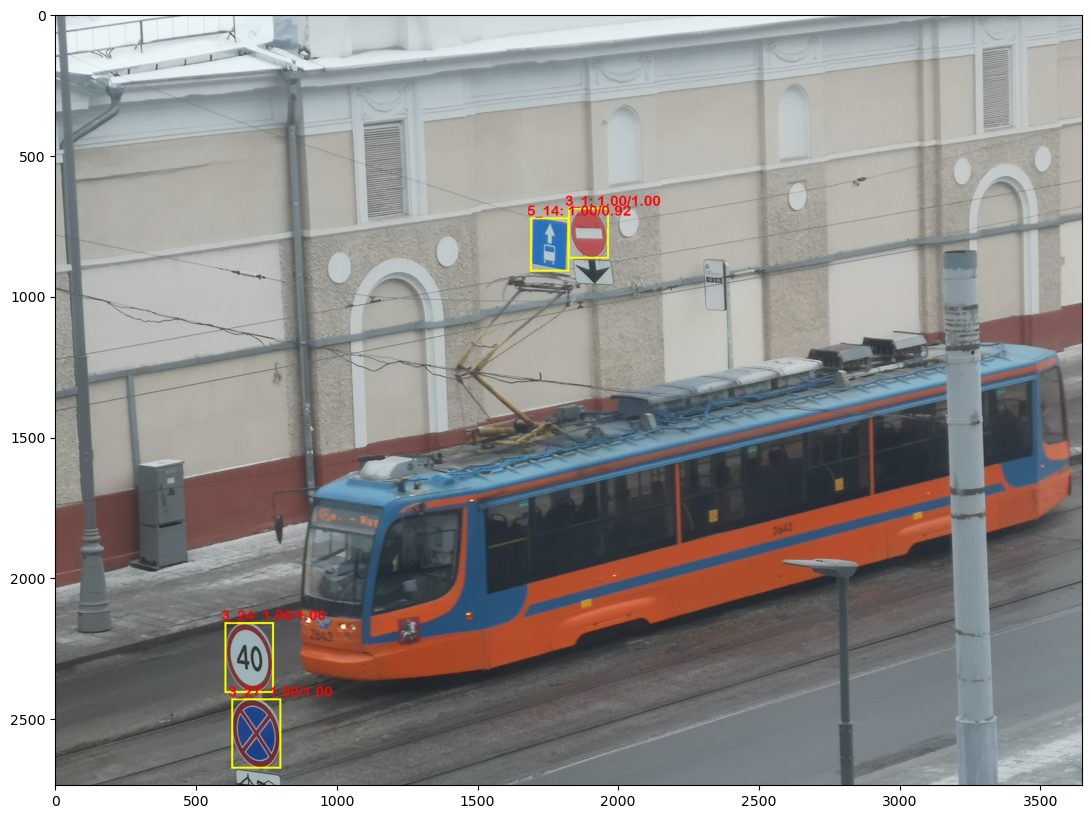

In [12]:
img_path = os.path.join('..','images','images_test','p20_8.jpg')
#img_path = cv2.imread(img_path)
img_pred, description = model.predict_single_visualized(img_path, display_img=True, save_path=None,
                                                        detector_threshold=None, classifier_threshold=None, debug_mode=False)

### Формирование аннотации для нескольких изображений в формате COCO

In [13]:
def predict_to_anno(model, img_list: list, data_path: str = None, anno_path_save: str = None, score_mode: str = 'both',
                    detector_threshold: float = None, classifier_threshold: float = None, debug_mode: float = False):
    """
    Сохраниние предсказаний по списку путей к изображениям в файл аннотации в формате COCO
    score_mode - сохраняемая уверенность: clf - классификатор, both - произведение скоров детектора и классификатора, None - без score
    на вход подается список путей к изображениям и пороги чувствительности детектора и классификатора
    при debug_mode=True выводятся детекции с любой уверенностью и  0-й класс (фон)
    """
    
    anno = {'images':[],
            'annotations':[],
            'categories':[[{'id': k}, {'name': v}] for k, v in model.class2label_map.items()]}
    if debug_mode != True:
        anno['categories'].pop(0) 
    
    for img_id, img_path in enumerate(img_list):
        
        # Исли указана папка с данными, образаем пути к изображениям
        if data_path:
            img_path, data_path = os.path.normpath(img_path), os.path.normpath(data_path)
            assert img_path[:len(data_path)] == data_path, 'Некорректно указаны пути к изображениям / каталогу с изображениями'
            file_name = img_path[len(data_path+os.sep):]
        else:
            file_name = img_path
        
        img = Image.open(img_path)
        anno['images'].append({'id': img_id,
                               'width': img.width,
                               'height': img.height,
                               'file_name': file_name})

        bboxes, pred_labels, pred_detector_scores, pred_classifier_scores = model.predict_single(img_path, detector_threshold,
                                                                                                 classifier_threshold, debug_mode)
        
        for anno_id in range(len(bboxes)):
            
            x1, y1, x2, y2 = bboxes[anno_id][0], bboxes[anno_id][1], bboxes[anno_id][2], bboxes[anno_id][3]
            width = x2 - x1
            height = y2 - y1
            
            if score_mode == 'both':
                score = pred_detector_scores[anno_id]*pred_classifier_scores[anno_id]
            elif score_mode == 'clf':
                score = pred_classifier_scores[anno_id]
            else:
                score = None

            anno['annotations'].append({'id': anno_id,
                                        'image_id': img_id,
                                        'category_id': pred_labels[anno_id],
                                        'area': width*height,
                                        'bbox': [x1, y1, width, height],
                                        'score': score,                         # для отображения в FiftyOne
                                        'iscrowd': 0})
            if score is None: anno['annotations'][-1].pop('score') 
    
    if anno_path_save:
        with open(anno_path_save, 'w') as f:
            json.dump(anno, f)
            
    return anno


images_dir = os.path.join('..', 'images', 'images_test')
img_list = [os.path.join(images_dir, img) for img in os.listdir(images_dir)]

prediction_anno = predict_to_anno(model, img_list, data_path=os.path.join('..', 'images', 'images_test'), #anno_path_save='anno.json',
                                  score_mode=None, detector_threshold=None, classifier_threshold=None, debug_mode=False)
prediction_anno

{'images': [{'id': 0, 'width': 3648, 'height': 2736, 'file_name': 'p20_1.jpg'},
  {'id': 1, 'width': 3648, 'height': 2736, 'file_name': 'p20_2.jpg'},
  {'id': 2, 'width': 3648, 'height': 2736, 'file_name': 'p20_3.jpg'},
  {'id': 3, 'width': 3648, 'height': 2736, 'file_name': 'p20_4.jpg'},
  {'id': 4, 'width': 3648, 'height': 2736, 'file_name': 'p20_5.jpg'},
  {'id': 5, 'width': 3648, 'height': 2736, 'file_name': 'p20_6.jpg'},
  {'id': 6, 'width': 3648, 'height': 2736, 'file_name': 'p20_7.jpg'},
  {'id': 7, 'width': 3648, 'height': 2736, 'file_name': 'p20_8.jpg'},
  {'id': 8, 'width': 3648, 'height': 2736, 'file_name': 'p20_9.jpg'},
  {'id': 9, 'width': 3735, 'height': 1522, 'file_name': 'screen1.jpg'},
  {'id': 10, 'width': 3749, 'height': 1521, 'file_name': 'screen2.jpg'}],
 'annotations': [{'id': 0,
   'image_id': 0,
   'category_id': 1,
   'area': 16002,
   'bbox': [2228, 1280, 127, 126],
   'iscrowd': 0},
  {'id': 1,
   'image_id': 0,
   'category_id': 7,
   'area': 15376,
   'bbox

### Предикт и визуализация для нескольких изображений (FiftyOne)

In [14]:
def predict_list_visualized(model, img_list: list, visual_score_mode: str = 'both',
                            detector_threshold: float = None, classifier_threshold: float = None, debug_mode: float = None):
    """Предикт для списка изображений и визуализация FiftyOne
    visual_score_mode - отображаемая уверенность: clf - классификатор, both - произведение скоров детектора и классификатора
    на вход подается список путей к изображениям и пороги чувствительности детектора и классификатора
    при debug_mode=True выводятся детекции с любой уверенностью и  0-й класс (фон)
    """
    dataset = fo.Dataset()

    for img_path in img_list:       
        
        img = Image.open(img_path)
        h, w = img.height, img.width

        bboxes, pred_labels, pred_detector_scores, pred_classifier_scores = model.predict_single(img, detector_threshold,
                                                                                                 classifier_threshold, debug_mode)
        detections = []
        for bbox, label, detector_score, classifier_score in zip(bboxes, pred_labels, pred_detector_scores, pred_classifier_scores):
            label_id = model.class2label_map[label]
            label_name = model.labels2names_map[label_id]
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]   
            score = detector_score*classifier_score if visual_score_mode=='both' else classifier_score
            detections.append(fo.Detection(label=f'{label_id} {label_name}',
                                           bounding_box=rel_box,
                                           confidence=score))
            
        sample = fo.Sample(filepath=img_path)  
        sample['detections'] = fo.Detections(detections=detections)
        dataset.add_sample(sample)

    fo.launch_app(dataset)
        
    return None


img_list = [os.path.join('..', 'images', 'images_test', 'p20_1.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_2.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_3.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_4.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_5.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_6.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_7.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_8.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_9.jpg'),     # фото из окна кабинета
            os.path.join('..', 'images', 'images_test', 'screen1.jpg'),   # скрин с яндекс карт
            os.path.join('..', 'images', 'images_test', 'screen2.jpg')]   # скрин с яндекс карт

predict_list_visualized(model, img_list, visual_score_mode='both',
                        detector_threshold=None, classifier_threshold=None, debug_mode=True)